In [1]:
!pip install neuralprophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 24.1 MB/s eta 0:00:00


In [2]:
from neuralprophet import NeuralProphet

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Path of folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/2024_08_27 Neural prophet main model/'

# Get list of all CSV files in the folder
csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty list to hold the dataframes
dfs = []

# Loop through the CSV files and read each one into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)

Mounted at /content/drive


In [5]:
data_selected = data[['Alarm Name', 'Alarm Location Info', 'First Occurred On', 'Site ID', 'Vendor', 'Domain', 'Device Type']]
data_selected.head(10)

,Alarm Name,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type
0,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN
1,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN
2,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN
3,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS
4,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN
5,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS
6,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN
7,No Solar Generation,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN
8,Mains Failure Alarm,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS
9,AC Failure,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN


In [6]:
# # prompt: get only alarms for site id PU0146

# PU0146_alarms = data_selected[data_selected['Site ID'] == 'AM0212']
# PU0146_alarms.head(10)



In [7]:
# prompt: encode the Alarm name column  and rename that column as y

le = LabelEncoder()
data_selected['y'] = le.fit_transform(data_selected['Alarm Name'])
PU0146_alarms = data_selected.drop('Alarm Name', axis=1)
PU0146_alarms.head(10)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-7-bfe825b21db0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['y'] = le.fit_transform(data_selected['Alarm Name'])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['y'] = le.fit_transform(data_selected['Alarm Name'])



,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type,y
0,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN,10
1,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN,10
2,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN,10
3,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS,156
4,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN,10
5,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS,156
6,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN,10
7,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN,124
8,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS,118
9,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN,5


In [8]:
# prompt: give mapping of encoded value to alarm name  print line by line

for i, alarm_name in enumerate(le.classes_):
  print(f'{i}: {alarm_name}')

0:  Phase L3 Failure
1:  Phase L3 Under Voltage
2: (PTP)Time synchronization faulty--2501553
3: (Sync E)The state of clock source is failed--2600422
4: (Sync E)The work mode of system clock is not in locked mode--2600420
5: AC Failure
6: AM_DOWNSHIFT
7: AUTOLOOPDETECT
8: AVG Two way Packet Loss Ratio
9: Air Conditioner External Fan Fault
10: Air Conditioner Frequent High Pressure
11: Air Conditioner High Temperature
12: All Lithium Battery Communication Failure
13: All Rectifiers Communication Failure
14: Ambient Temperature Unacceptable
15: BB Discharge 95 percent DoD
16: BBU CPRI Interface Error
17: BBU CPRI Optical Module or Electrical Port Not Ready
18: BD_STATUS
19: BFD session down
20: BGP Status Changed
21: BLVD Disconnected
22: BMU Missing
23: BSS_GCell-Call_Setup_Suc_Rate_Cell_Huawei2G
24: BSS_GCell-H-Call_Drop_Rate_Trend_Huawei2G
25: BSS_LCell-UL_Avg_Tpt
26: BSS_LCell-eRAB_Drop_Rate
27: BSS_LCell_QCI1_eRAB_Suc_Rate
28: BUS_ERR
29: Battery Deep Discharge Alarm
30: Battery Fuse

In [9]:
# prompt: rename first occured column as ds

data_selected = data_selected.rename(columns={'First Occurred On': 'ds'})
data_selected.head(10)


,Alarm Name,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN,10
1,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN,10
2,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN,10
3,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS,156
4,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN,10
5,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS,156
6,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN,10
7,No Solar Generation,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN,124
8,Mains Failure Alarm,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS,118
9,AC Failure,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN,5


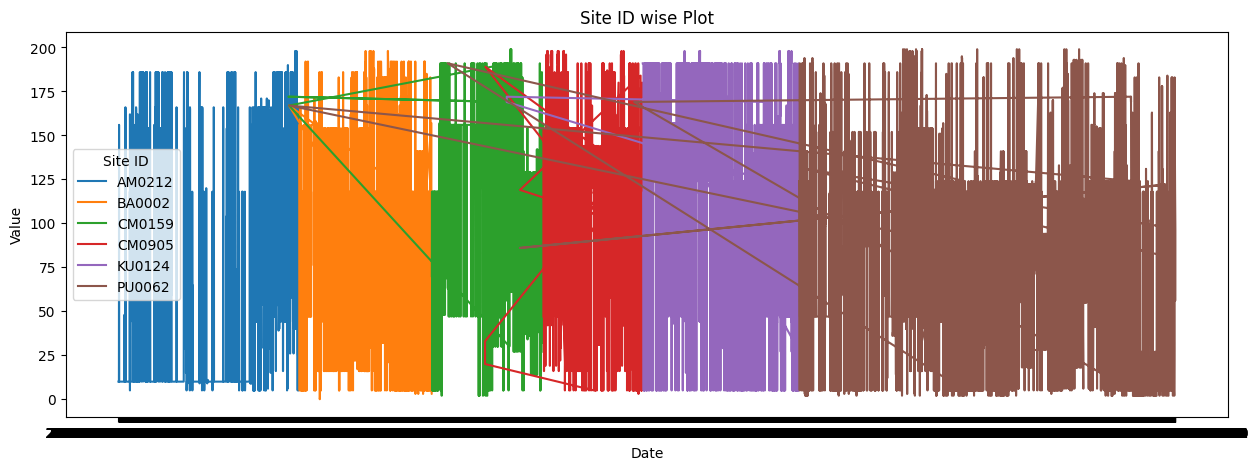

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot grouped by Site ID
plt.figure(figsize=(15, 5))

for site_id, group_data in data_selected.groupby('Site ID'):
    plt.plot(group_data['ds'], group_data['y'], label=site_id)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Site ID wise Plot')
plt.legend(title='Site ID')
plt.show()

In [11]:
# prompt: sort accoding to ds column latest alarms

data_selected['ds'] = pd.to_datetime(data_selected['ds'])
data_selected = data_selected.sort_values(by='ds', ascending=False)
data_selected.head(10)


,Alarm Name,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN,10
1,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN,10
2,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN,10
3,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS,156
4,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN,10
5,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS,156
6,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN,10
7,No Solar Generation,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN,124
8,Mains Failure Alarm,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS,118
9,AC Failure,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN,5


In [12]:
data_selected.head(100)


,Alarm Name,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN,10
1,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN,10
2,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN,10
3,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS,156
4,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN,10
...,...,...,...,...,...,...,...,...
91,Cell Unavailable,"eNodeB Function Name=Sapumal_Place-CM0905-HOP,...",2024-08-25 13:41:04,CM0905,HUAWEI,Access,eNodeB,47
92,Vty Exceed,source=SAPUMAL_PLACE-CMBC-ACC10-R6-N1-01 locat...,2024-08-25 13:41:02,CM0905,HUAWEI,IPCore,Unknown,196
93,Cell Unavailable,"eNodeB Function Name=Sapumal_Place-CM0905-HOP,...",2024-08-25 13:41:01,CM0905,HUAWEI,Access,eNodeB,47
94,Cell Unavailable,"eNodeB Function Name=Sapumal_Place-CM0905-HOP,...",2024-08-25 13:41:01,CM0905,HUAWEI,Access,eNodeB,47


In [13]:
# prompt: drop rows with y is unknown

data_selected = data_selected[data_selected['y'] != 'Unknown']

In [14]:
# prompt: remove duplicates in ds

data_selected = data_selected.drop_duplicates(subset=['ds'])
data_selected.head(10)


,Alarm Name,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 23:36:16,AM0212,HUAWEI,Power,NaN,10
1,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 22:27:09,AM0212,HUAWEI,Power,NaN,10
2,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 21:19:01,AM0212,HUAWEI,Power,NaN,10
3,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=132, Slot No.=0, TX...",2024-08-25 21:09:23,BA0002,HUAWEI,Access,GBTS,156
4,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 20:10:55,AM0212,HUAWEI,Power,NaN,10
5,RF Unit TX Channel Gain Out of Range,"Cabinet No.=0, Subrack No.=62, Slot No.=0, TX ...",2024-08-25 19:53:23,AM0212,HUAWEI,Access,GBTS,156
6,Air Conditioner Frequent High Pressure,NodeB IP:10.145.187.30; Site ID:AM0212; Kalmun...,2024-08-25 19:02:45,AM0212,HUAWEI,Power,NaN,10
7,No Solar Generation,Site ID:PU0062; Channnel IP:10.145.144.30; Nag...,2024-08-25 18:06:48,PU0062,HUAWEI,Power,NaN,124
8,Mains Failure Alarm,"Cabinet No.=0, Subrack No.=0, Slot No.=19, Por...",2024-08-25 18:04:27,PU0062,HUAWEI,Power,GBTS,118
9,AC Failure,NodeB IP:10.145.144.30; Site ID:PU0062; Nagawi...,2024-08-25 18:04:19,PU0062,HUAWEI,Power,NaN,5


In [15]:
# prompt: keep only ds and y columns

# Keep only 'ds' and 'y' columns (preprocessing for NeuralProphet)
data_selected = data_selected[['ds', 'y', 'Site ID']]
data_selected.head(10)


,ds,y,Site ID
0,2024-08-25 23:36:16,10,AM0212
1,2024-08-25 22:27:09,10,AM0212
2,2024-08-25 21:19:01,10,AM0212
3,2024-08-25 21:09:23,156,BA0002
4,2024-08-25 20:10:55,10,AM0212
5,2024-08-25 19:53:23,156,AM0212
6,2024-08-25 19:02:45,10,AM0212
7,2024-08-25 18:06:48,124,PU0062
8,2024-08-25 18:04:27,118,PU0062
9,2024-08-25 18:04:19,5,PU0062


In [16]:
# # Import the NeuralProphet class
# from neuralprophet import NeuralProphet, set_log_level

# # Disable logging messages unless there is an error
# set_log_level("ERROR")

# PU0146_alarms['ds'] = pd.to_datetime(PU0146_alarms['ds'])  # Ensure 'ds' is datetime
# PU0146_alarms = PU0146_alarms.set_index('ds').resample('H').mean().reset_index()

# # Create a NeuralProphet model with default parameters
# # Set the learning rate and define other hyperparameters directly
# m = NeuralProphet(
#     learning_rate=0.01,          # Set the learning rate to 0.005
#     batch_size=32,
#     seasonality_mode='additive',  # Seasonality mode (choose between 'additive' or 'multiplicative')
# )

# # Use static plotly in notebooks
# m.set_plotting_backend("plotly-static")

from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import matplotlib.pyplot as plt
import os

# Disable logging messages unless there is an error
set_log_level("ERROR")

models = []

# Loop through each site and fit a separate model on its dataset
for site_id, site_data in data_selected.groupby('Site ID'):
    # Resample data by hour
    site_data['ds'] = pd.to_datetime(site_data['ds']) # Ensure 'ds' is datetime
    site_data = site_data.set_index('ds')[['y']].resample('H').mean().reset_index() # Resample to hourly and reset index

    # Remove duplicate 'ds' values if any exist after resampling
    site_data = site_data.drop_duplicates(subset=['ds'])

    # Fill missing values after resampling (if any) - this helps maintain a consistent frequency
    site_data = site_data.fillna(method='ffill') # Forward fill missing values

    # Check for irregularities in the time series and print a warning if found
    if not pd.infer_freq(site_data['ds']):
        print(f"Warning: Irregular time intervals detected for Site ID: {site_id}")

    # Create a NeuralProphet model
    m = NeuralProphet(
        learning_rate=0.01,
        batch_size=32,
        seasonality_mode='additive',
    )

    # Fit the model on the site's data
    metrics = m.fit(site_data)

    # Append the trained model to the list
    models.append(m)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-16-4f51a9d54a9a>:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  site_data = site_data.fillna(method='ffill') # Forward fill missing values

  site_data = site_data.fillna(method='ffill') # Forward fill missing values



Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 27. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - <ipython-input-16-4f51a9d54a9a>:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  site_data = site_data.fillna(method='ffill') # Forward fill missing values

  site_data = site_data.fillna(method='ffill') # Forward fill missing values



Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - <ipython-input-16-4f51a9d54a9a>:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  site_data = site_data.fillna(method='ffill') # Forward fill missing values

  site_data = site_data.fillna(method='ffill') # Forward fill missing values



Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 13. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - <ipython-input-16-4f51a9d54a9a>:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  site_data = site_data.fillna(method='ffill') # Forward fill missing values

  site_data = site_data.fillna(method='ffill') # Forward fill missing values



Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 28. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - <ipython-input-16-4f51a9d54a9a>:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  site_data = site_data.fillna(method='ffill') # Forward fill missing values

  site_data = site_data.fillna(method='ffill') # Forward fill missing values



Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - <ipython-input-16-4f51a9d54a9a>:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  site_data = site_data.fillna(method='ffill') # Forward fill missing values

  site_data = site_data.fillna(method='ffill') # Forward fill missing values



Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




In [17]:
# prompt: where those duplicate values

# Find duplicate rows based on all columns
duplicate_rows = data_selected[data_selected.duplicated(keep=False)]

# Print the duplicate rows
print(duplicate_rows)


Empty DataFrame
Columns: [ds, y, Site ID]
Index: []


In [18]:
# Function to predict using the generalized model
def predict_with_generalized_model(input_data):
    input_data['ds'] = pd.to_datetime(input_data['ds'])
     # Select only the 'y' column before resampling to avoid including 'Site ID'
    input_data = input_data.set_index('ds')[['y']].resample('H').mean().reset_index()

    # Combine forecasts from all models
    combined_forecast = pd.DataFrame()

    for model in models:
        # Create a future dataframe reaching 24*7 into the future
        df_future = model.make_future_dataframe(input_data, n_historic_predictions=True, periods=24*7)

        # Predict the future
        forecast = model.predict(df_future)
        combined_forecast = pd.concat([combined_forecast, forecast[['ds', 'yhat1']]], axis=1)

    # Average the predictions across all models
    combined_forecast['yhat_mean'] = combined_forecast.filter(like='yhat1').mean(axis=1)

    return combined_forecast[['ds', 'yhat_mean']]


WARNING - (py.warnings._showwarnmsg) - <ipython-input-18-22ab48bd692f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty

Forecasting for Site ID: AM0212


Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

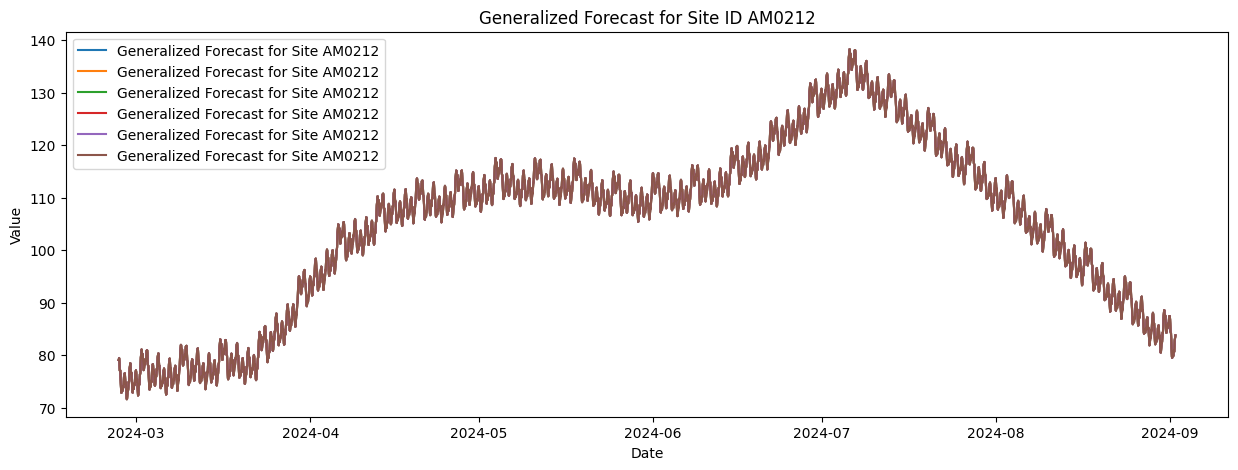

WARNING - (py.warnings._showwarnmsg) - <ipython-input-18-22ab48bd692f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty

Forecasting for Site ID: BA0002


Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

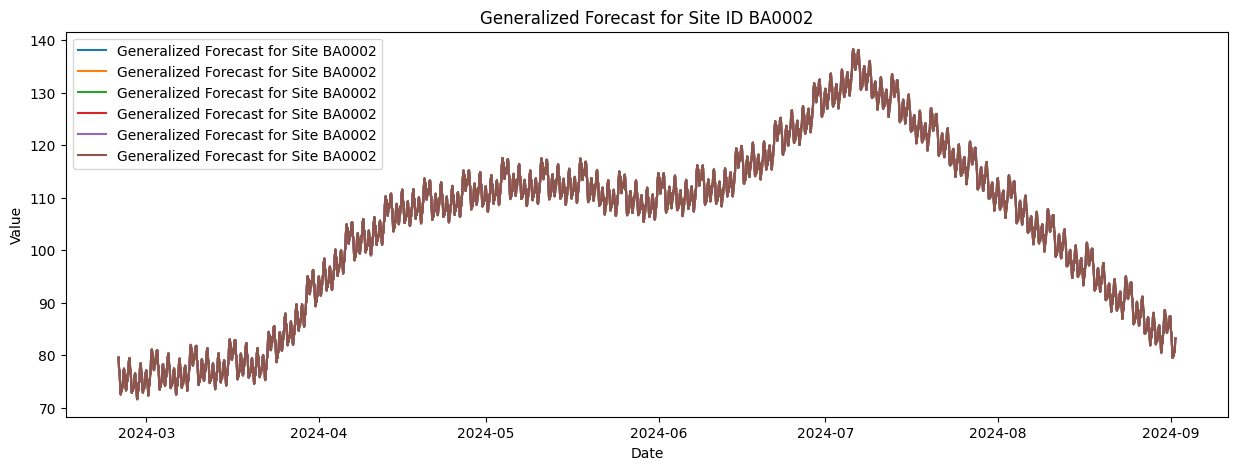

WARNING - (py.warnings._showwarnmsg) - <ipython-input-18-22ab48bd692f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty

Forecasting for Site ID: PU0062


Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

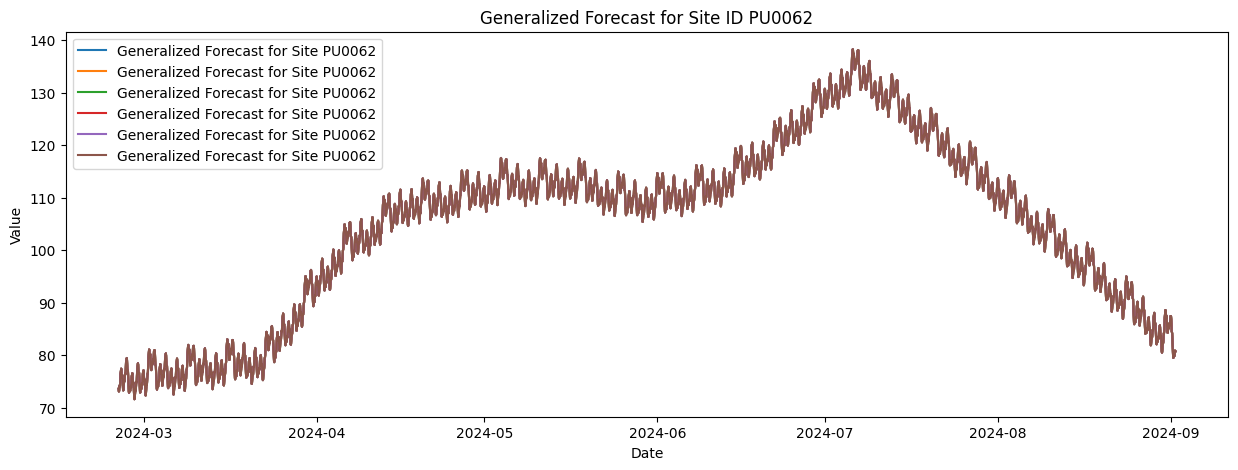

WARNING - (py.warnings._showwarnmsg) - <ipython-input-18-22ab48bd692f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty

Forecasting for Site ID: KU0124


Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

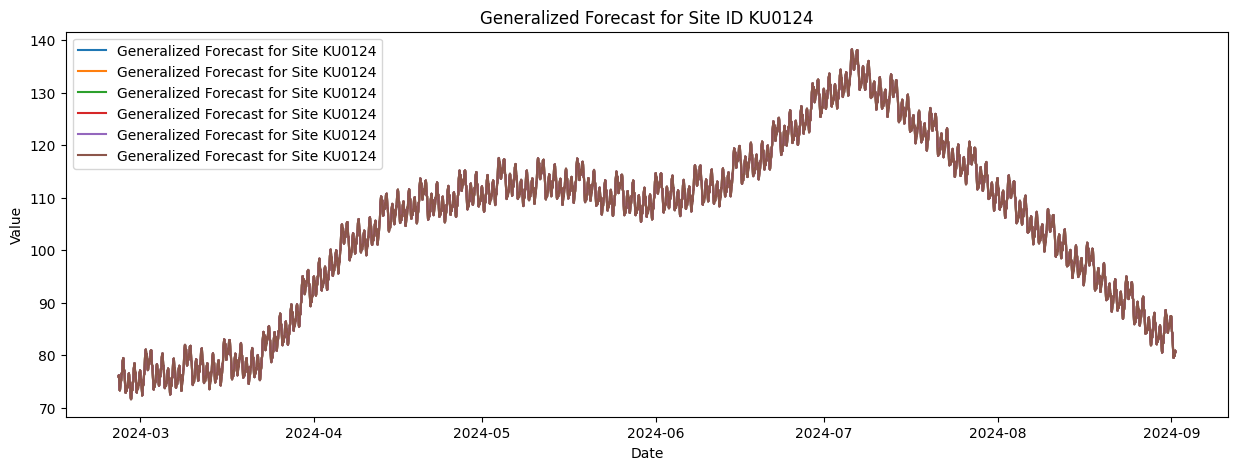

WARNING - (py.warnings._showwarnmsg) - <ipython-input-18-22ab48bd692f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty

Forecasting for Site ID: CM0905


Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

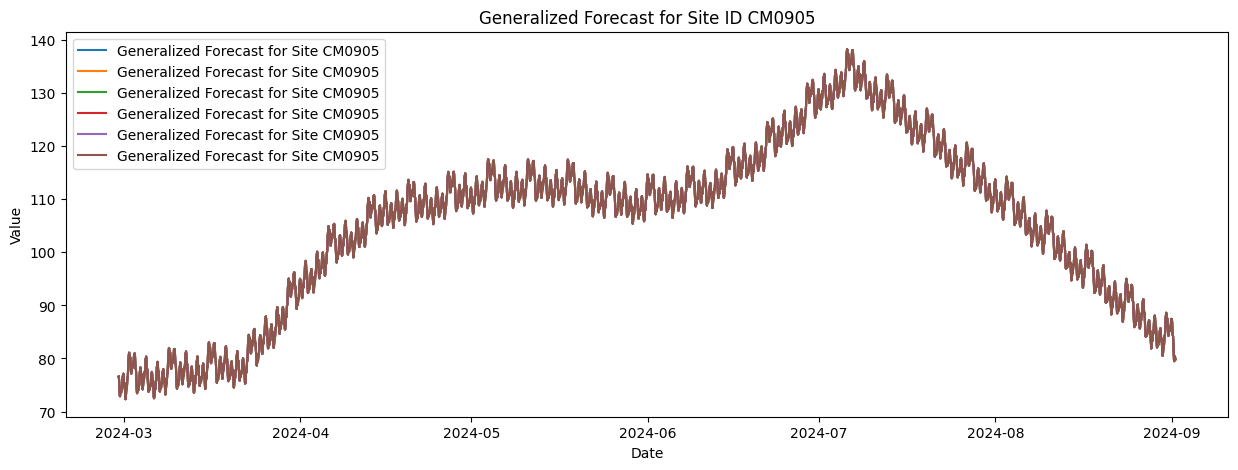

WARNING - (py.warnings._showwarnmsg) - <ipython-input-18-22ab48bd692f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['ds'] = pd.to_datetime(input_data['ds'])

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty

Forecasting for Site ID: CM0159


Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

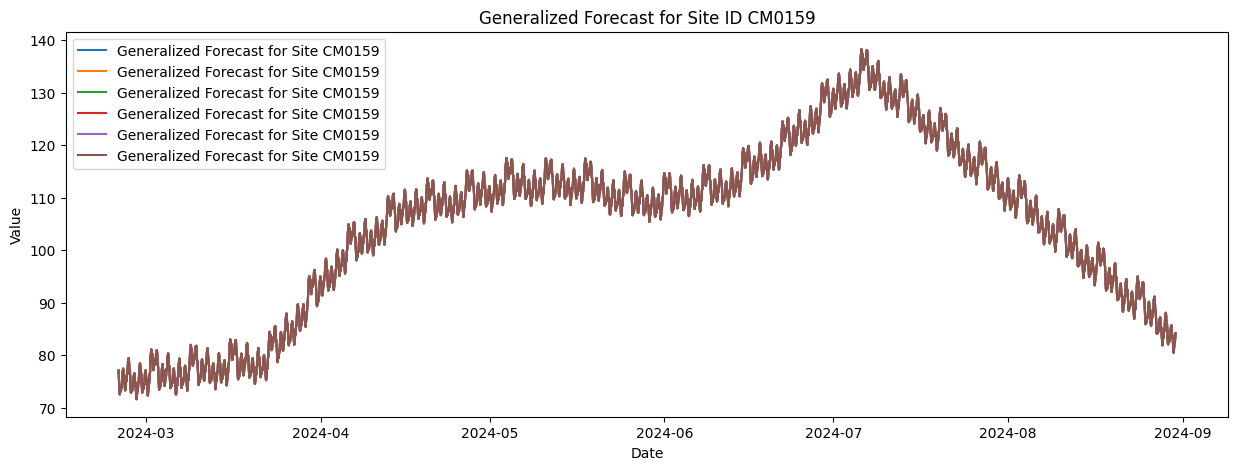

In [19]:
# # Create a new dataframe reaching 24*7 into the future for our forecast, n_historic_predictions also shows historic data
# df_future = m.make_future_dataframe(PU0146_alarms, n_historic_predictions=True, periods=24*7)

# # Predict the future
# forecast = m.predict(df_future)

# # Visualize the forecast
# m.plot(forecast)
# List of site IDs you want to forecast for
site_ids = data_selected['Site ID'].unique()

# Loop through each site ID and generate forecasts
for site_id in site_ids:
    print(f"Forecasting for Site ID: {site_id}")

    # Filter the data for the specific site ID
    site_data = data_selected[data_selected['Site ID'] == site_id]

    # Example: Predict for the site dataset using the generalized model
    forecast = predict_with_generalized_model(site_data)

    # Plot the generalized forecast for the current site ID
    plt.figure(figsize=(15, 5))
    plt.plot(forecast['ds'], forecast['yhat_mean'], label=f'Generalized Forecast for Site {site_id}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Generalized Forecast for Site ID {site_id}')
    plt.legend()
    plt.show()

In [20]:
# prompt: now the model is fitted, so now  Create a new dataframe reaching 7 days into the future for our forecast for sit CM0159

# Filter data for site CM0159
site_data_CM0159 = data_selected[data_selected['Site ID'] == 'CM0159']

# Create a future dataframe reaching 7 days into the future
future_df_CM0159 = m.make_future_dataframe(site_data_CM0159, periods=24*7)


Predicting: |          | 0/? [00:00<?, ?it/s]

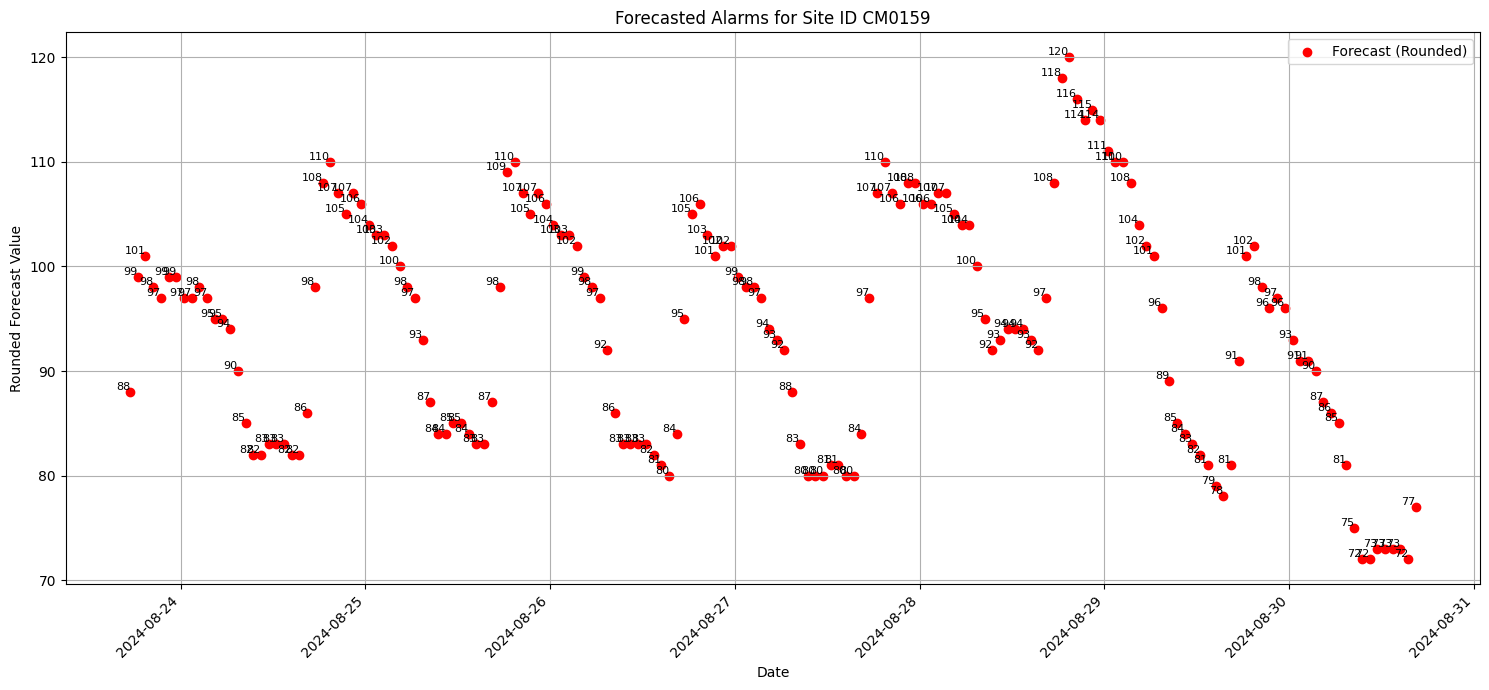

In [21]:

# Create a future dataframe reaching 7 days into the future
future_df_CM0159 = m.make_future_dataframe(site_data_CM0159[['ds','y']], periods=24*7)

# Predict the future
forecast_CM0159 = m.predict(future_df_CM0159)

# Round predictions to the nearest positive integer
forecast_CM0159['yhat1'] = forecast_CM0159['yhat1'].round().clip(lower=0).astype(int)

# Plot 'yhat1' as dots on the forecast plot
plt.figure(figsize=(15, 7))  # Create a new figure with adjusted size
plt.scatter(forecast_CM0159['ds'], forecast_CM0159['yhat1'], color='red', label='Forecast (Rounded)')

# Add labels to data points (only label non-zero predictions)
for i, row in forecast_CM0159.iterrows():
    if row['yhat1'] > 0:
        plt.text(row['ds'], row['yhat1'], f'{row["yhat1"]}', fontsize=8, ha='right', va='bottom')

plt.xlabel('Date')
plt.ylabel('Rounded Forecast Value')
plt.title('Forecasted Alarms for Site ID CM0159')
plt.legend()
plt.grid(True)  # Add grid lines for better readability

# Set x-axis ticks to show all dates, rotate for better readability
plt.xticks(rotation=45, ha='right')

# Automatically set y-axis ticks based on data
plt.yticks()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot